In [1]:
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

## Read data

In [3]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [4]:
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Gene selection by detection, high variability, normalizing every cell by its initial size and logarithmizing X

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Test

In [6]:
gene = "Rps3"
s = adata.layers['spliced'][:, adata.var.index == gene].toarray()[:,0]
u = adata.layers['unspliced'][:, adata.var.index == gene].toarray()[:,0]
c = adata.obs['clusters']

<AxesSubplot:>

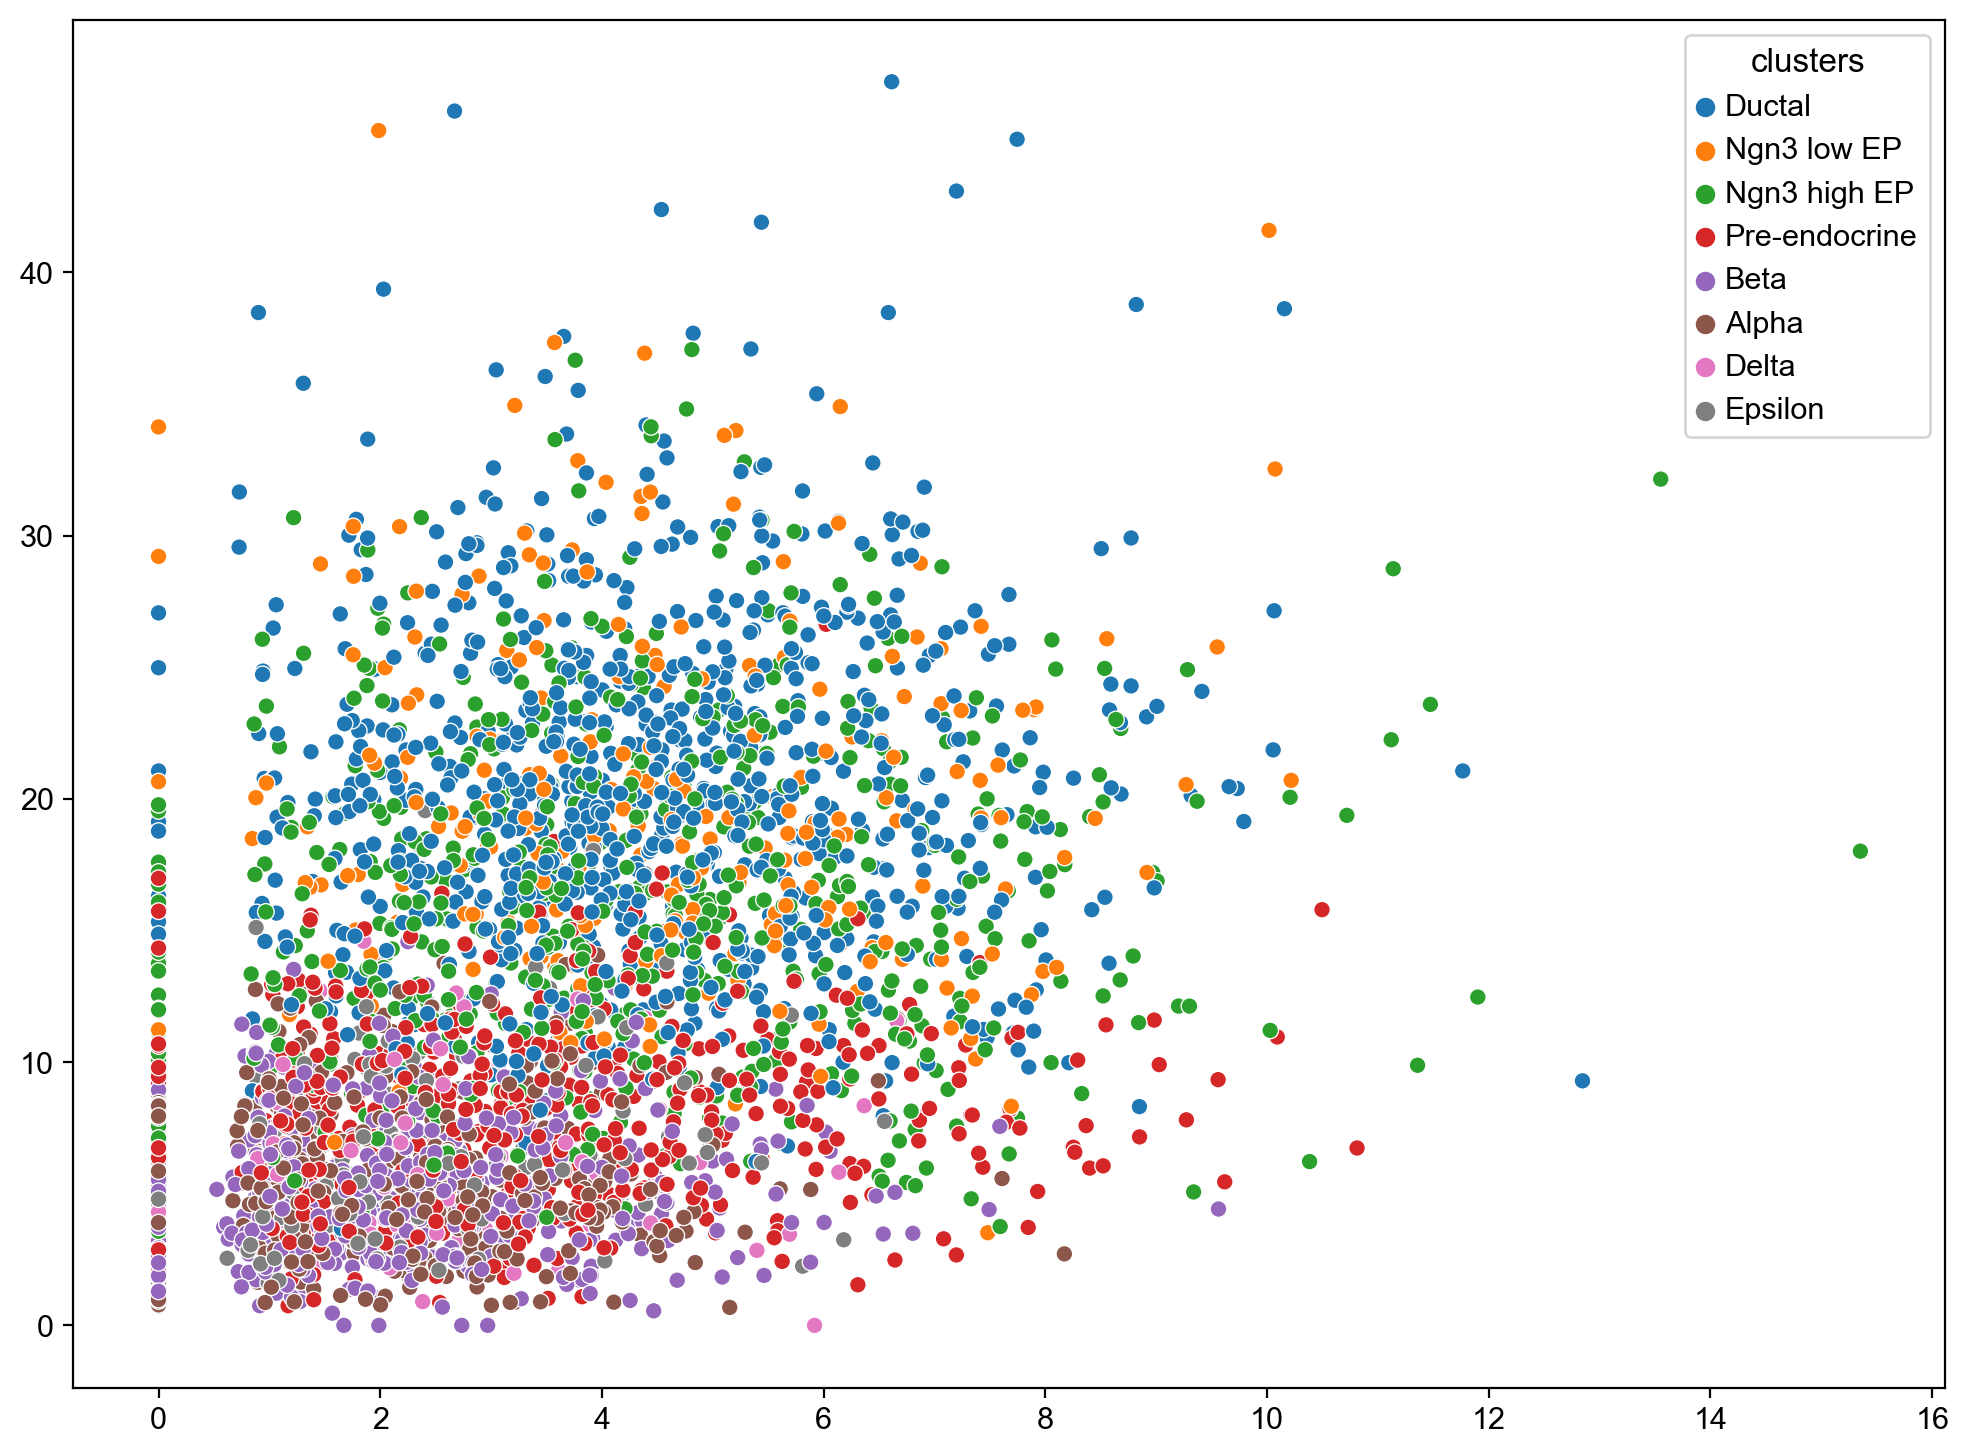

In [7]:
fig = plt.figure(figsize=(12, 9))
sns.scatterplot(x=s, y=u, hue=c, ax=fig.gca())

In [8]:
fig.savefig("../pics/Rps3_phase_portrait_spun.png")

In [9]:
gene = "Rps3"
s = adata.layers['Ms'][:, adata.var.index == gene][:,0]
u = adata.layers['Mu'][:, adata.var.index == gene][:,0]
c = adata.obs['clusters']

<AxesSubplot:>

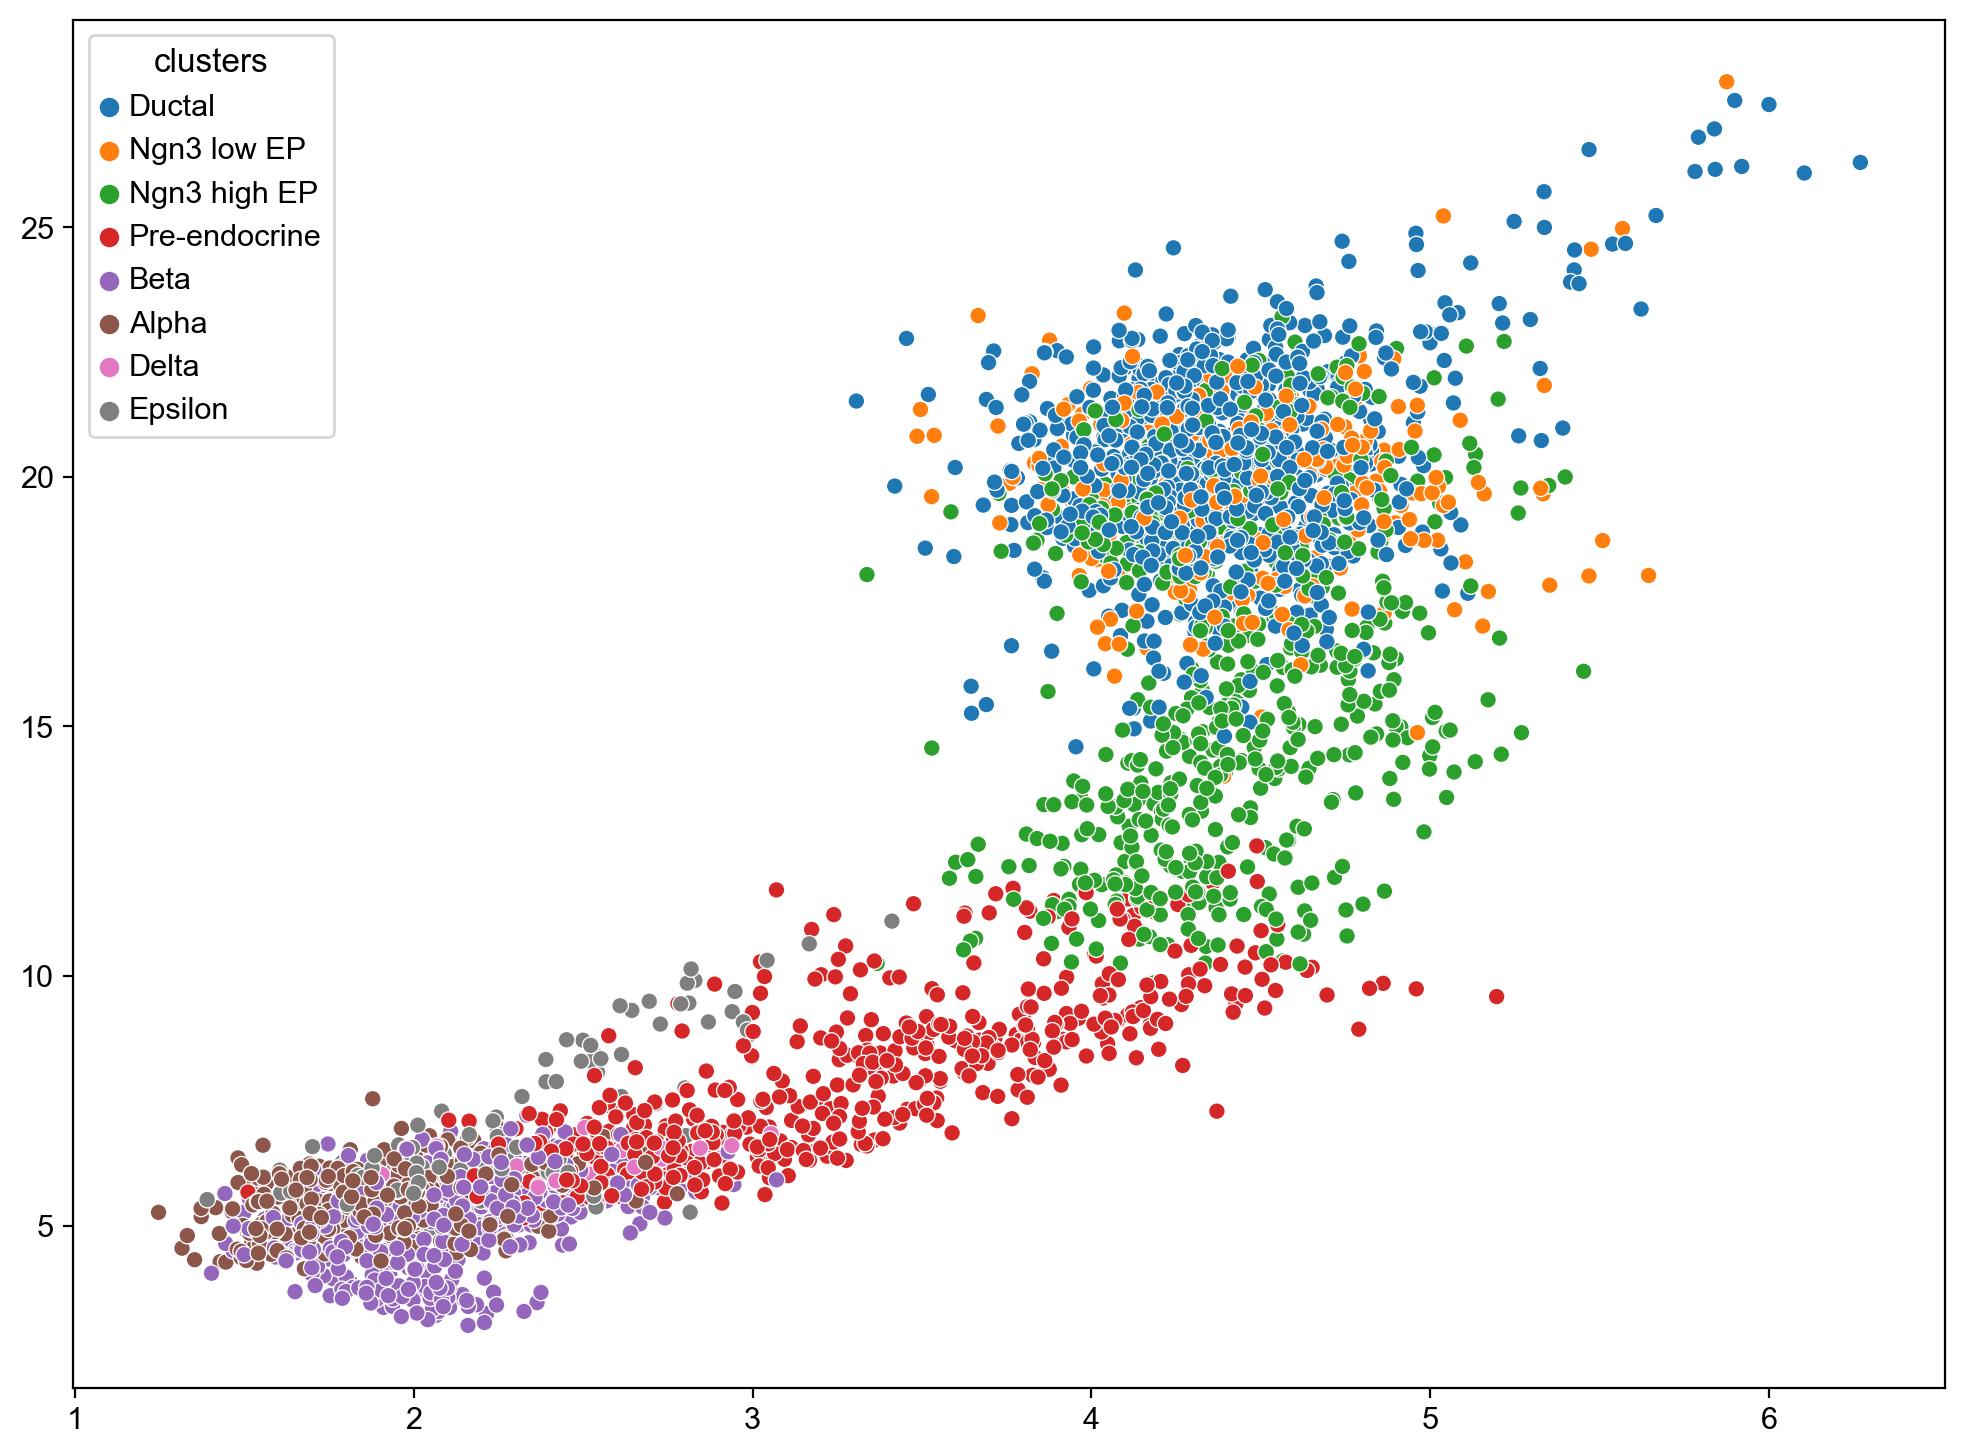

In [10]:
fig = plt.figure(figsize=(12, 9))
sns.scatterplot(x=s, y=u, hue=c, ax=fig.gca())

In [11]:
fig.savefig("../pics/Rps3_phase_portrait_MsMu.png")

In [12]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(adata.obsp['connectivities'].toarray())

True

## Scvelo package

In [13]:
def select_distances(dist, n_neighbors=None):
    D = dist.copy()
    n_counts = (D > 0).sum(1).A1 if issparse(D) else (D > 0).sum(1)
    n_neighbors = (
        n_counts.min() if n_neighbors is None else min(n_counts.min(), n_neighbors)
    )
    rows = np.where(n_counts > n_neighbors)[0]
    cumsum_neighs = np.insert(n_counts.cumsum(), 0, 0)
    dat = D.data

    for row in rows:
        n0, n1 = cumsum_neighs[row], cumsum_neighs[row + 1]
        rm_idx = n0 + dat[n0:n1].argsort()[n_neighbors:]
        dat[rm_idx] = 0
    D.eliminate_zeros()
    return D

In [14]:
from scipy.sparse import issparse

def select_connectivities(connectivities, n_neighbors=None):
    C = connectivities.copy()
    n_counts = (C > 0).sum(1).A1 if issparse(C) else (C > 0).sum(1)
    n_neighbors = (
        n_counts.min() if n_neighbors is None else min(n_counts.min(), n_neighbors)
    )
    rows = np.where(n_counts > n_neighbors)[0]
    cumsum_neighs = np.insert(n_counts.cumsum(), 0, 0)
    dat = C.data

    for row in rows:
        n0, n1 = cumsum_neighs[row], cumsum_neighs[row + 1]
        rm_idx = n0 + dat[n0:n1].argsort()[::-1][n_neighbors:]
        dat[rm_idx] = 0
    C.eliminate_zeros()
    return C

In [15]:
def get_neighs(adata, mode="distances"):
    if hasattr(adata, "obsp") and mode in adata.obsp.keys():
        return adata.obsp[mode]
    elif "neighbors" in adata.uns.keys() and mode in adata.uns["neighbors"]:
        return adata.uns["neighbors"][mode]
    else:
        raise ValueError("The selected mode is not valid.")


def get_n_neighs(adata):
    return adata.uns.get("neighbors", {}).get("params", {}).get("n_neighbors", 0)

In [16]:
import warnings

def get_connectivities(adata, mode="connectivities", n_neighbors=None):
    if "neighbors" in adata.uns.keys():
        C = get_neighs(adata, mode)
        if n_neighbors is not None and n_neighbors < get_n_neighs(adata):
            if mode == "connectivities":
                C = select_connectivities(C, n_neighbors)
            else:
                C = select_distances(C, n_neighbors)
        connectivities = C > 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            connectivities.setdiag(1)
            connectivities = connectivities.multiply(1.0 / connectivities.sum(1))
        return connectivities.tocsr().astype(np.float32)
    else:
        return None

In [17]:
connectivities = get_connectivities(adata, 'connectivities', n_neighbors=30).toarray()

<AxesSubplot:>

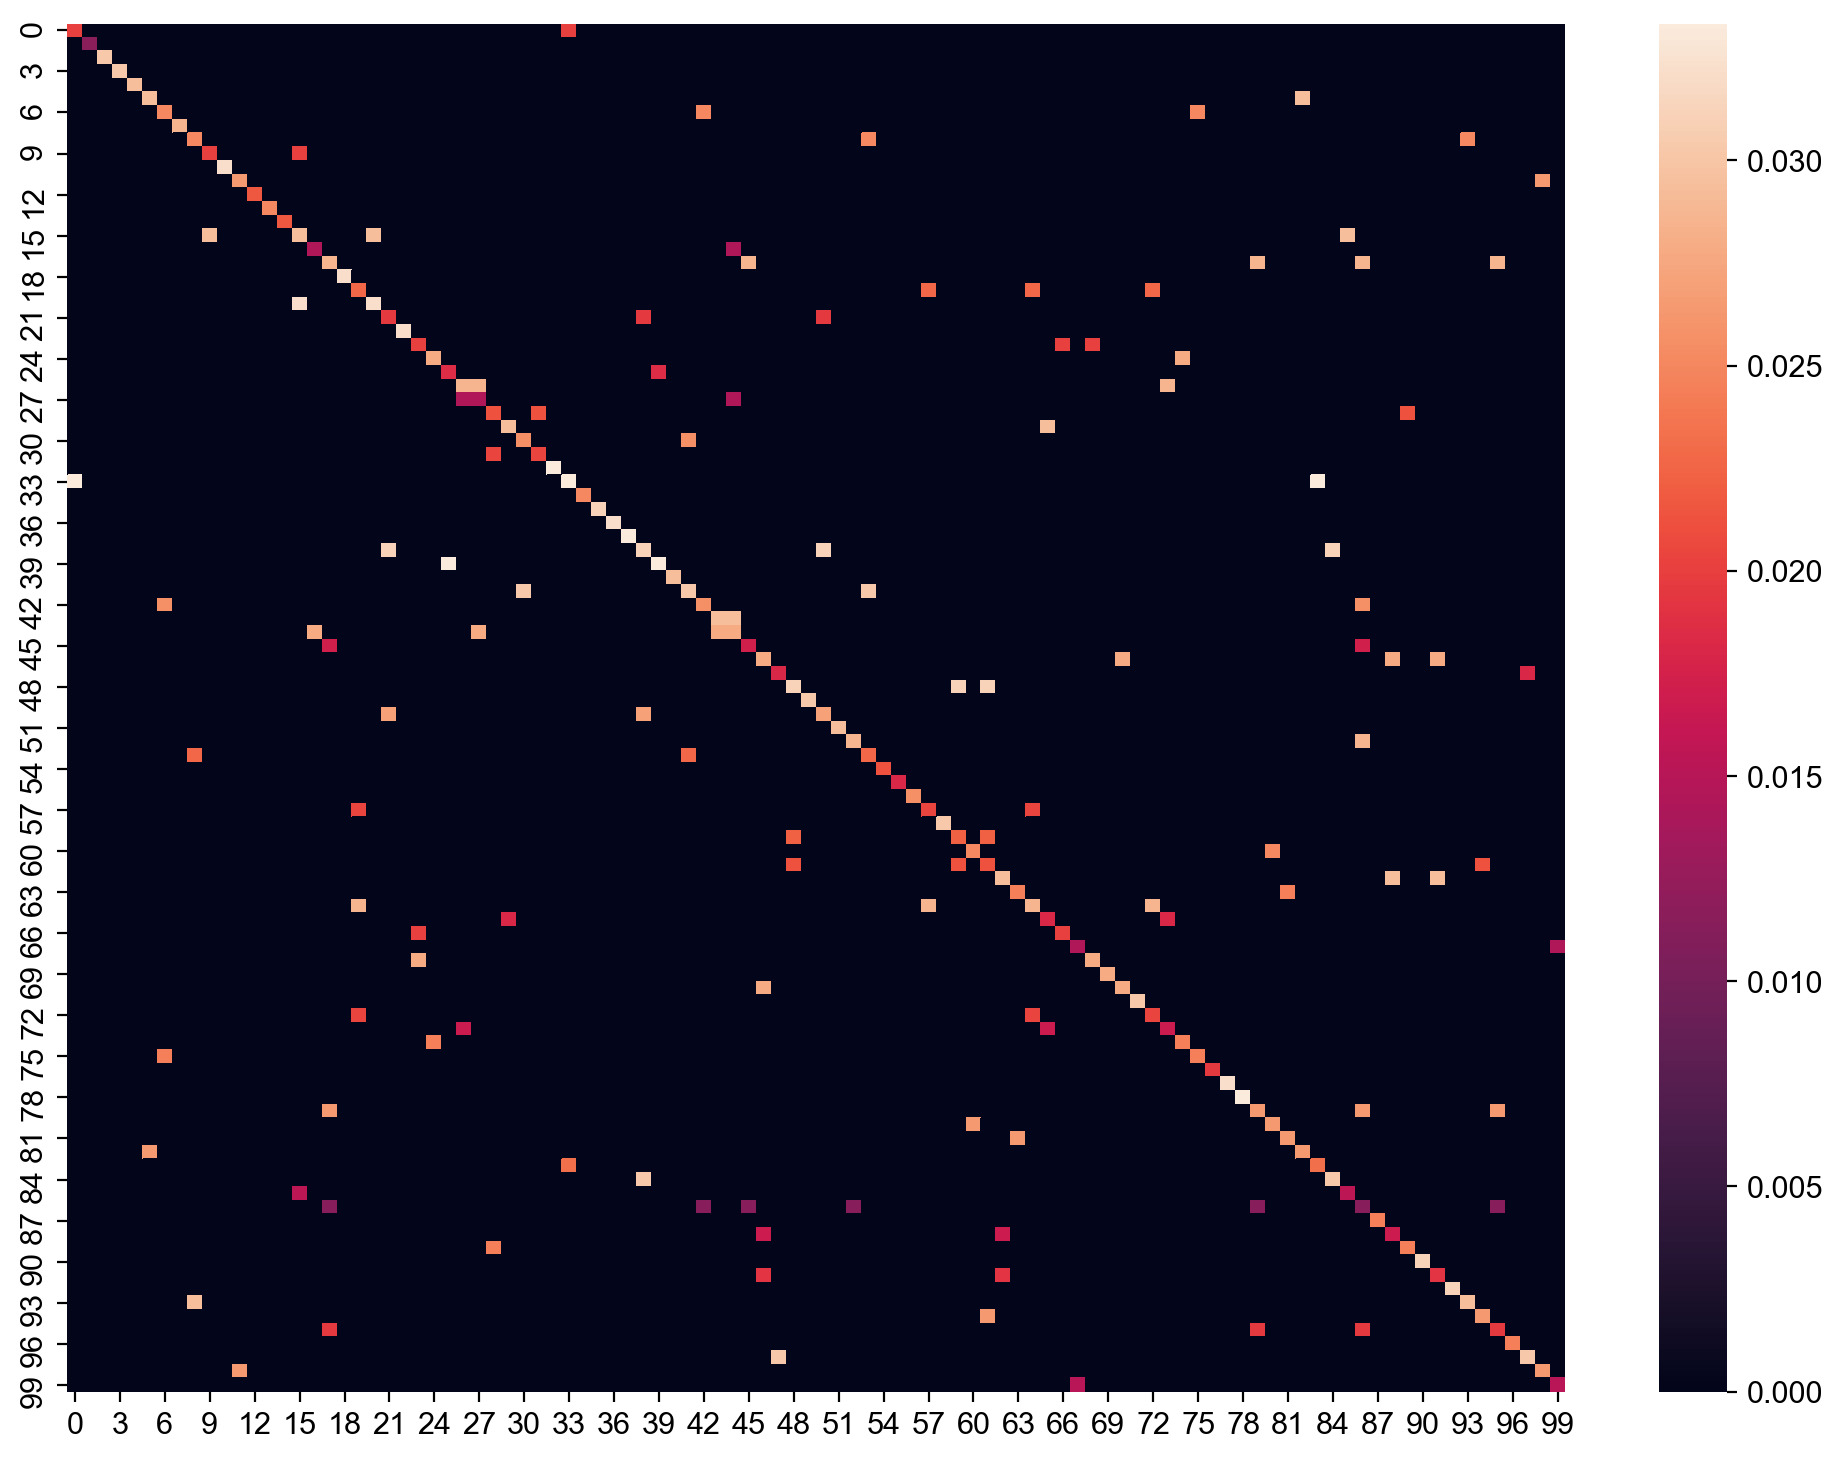

In [18]:
fig = plt.figure(figsize=(12, 9))
sns.heatmap(connectivities[:100, :100], ax=fig.gca())

In [19]:
fig.savefig("../pics/get_connectivities.png")

<AxesSubplot:>

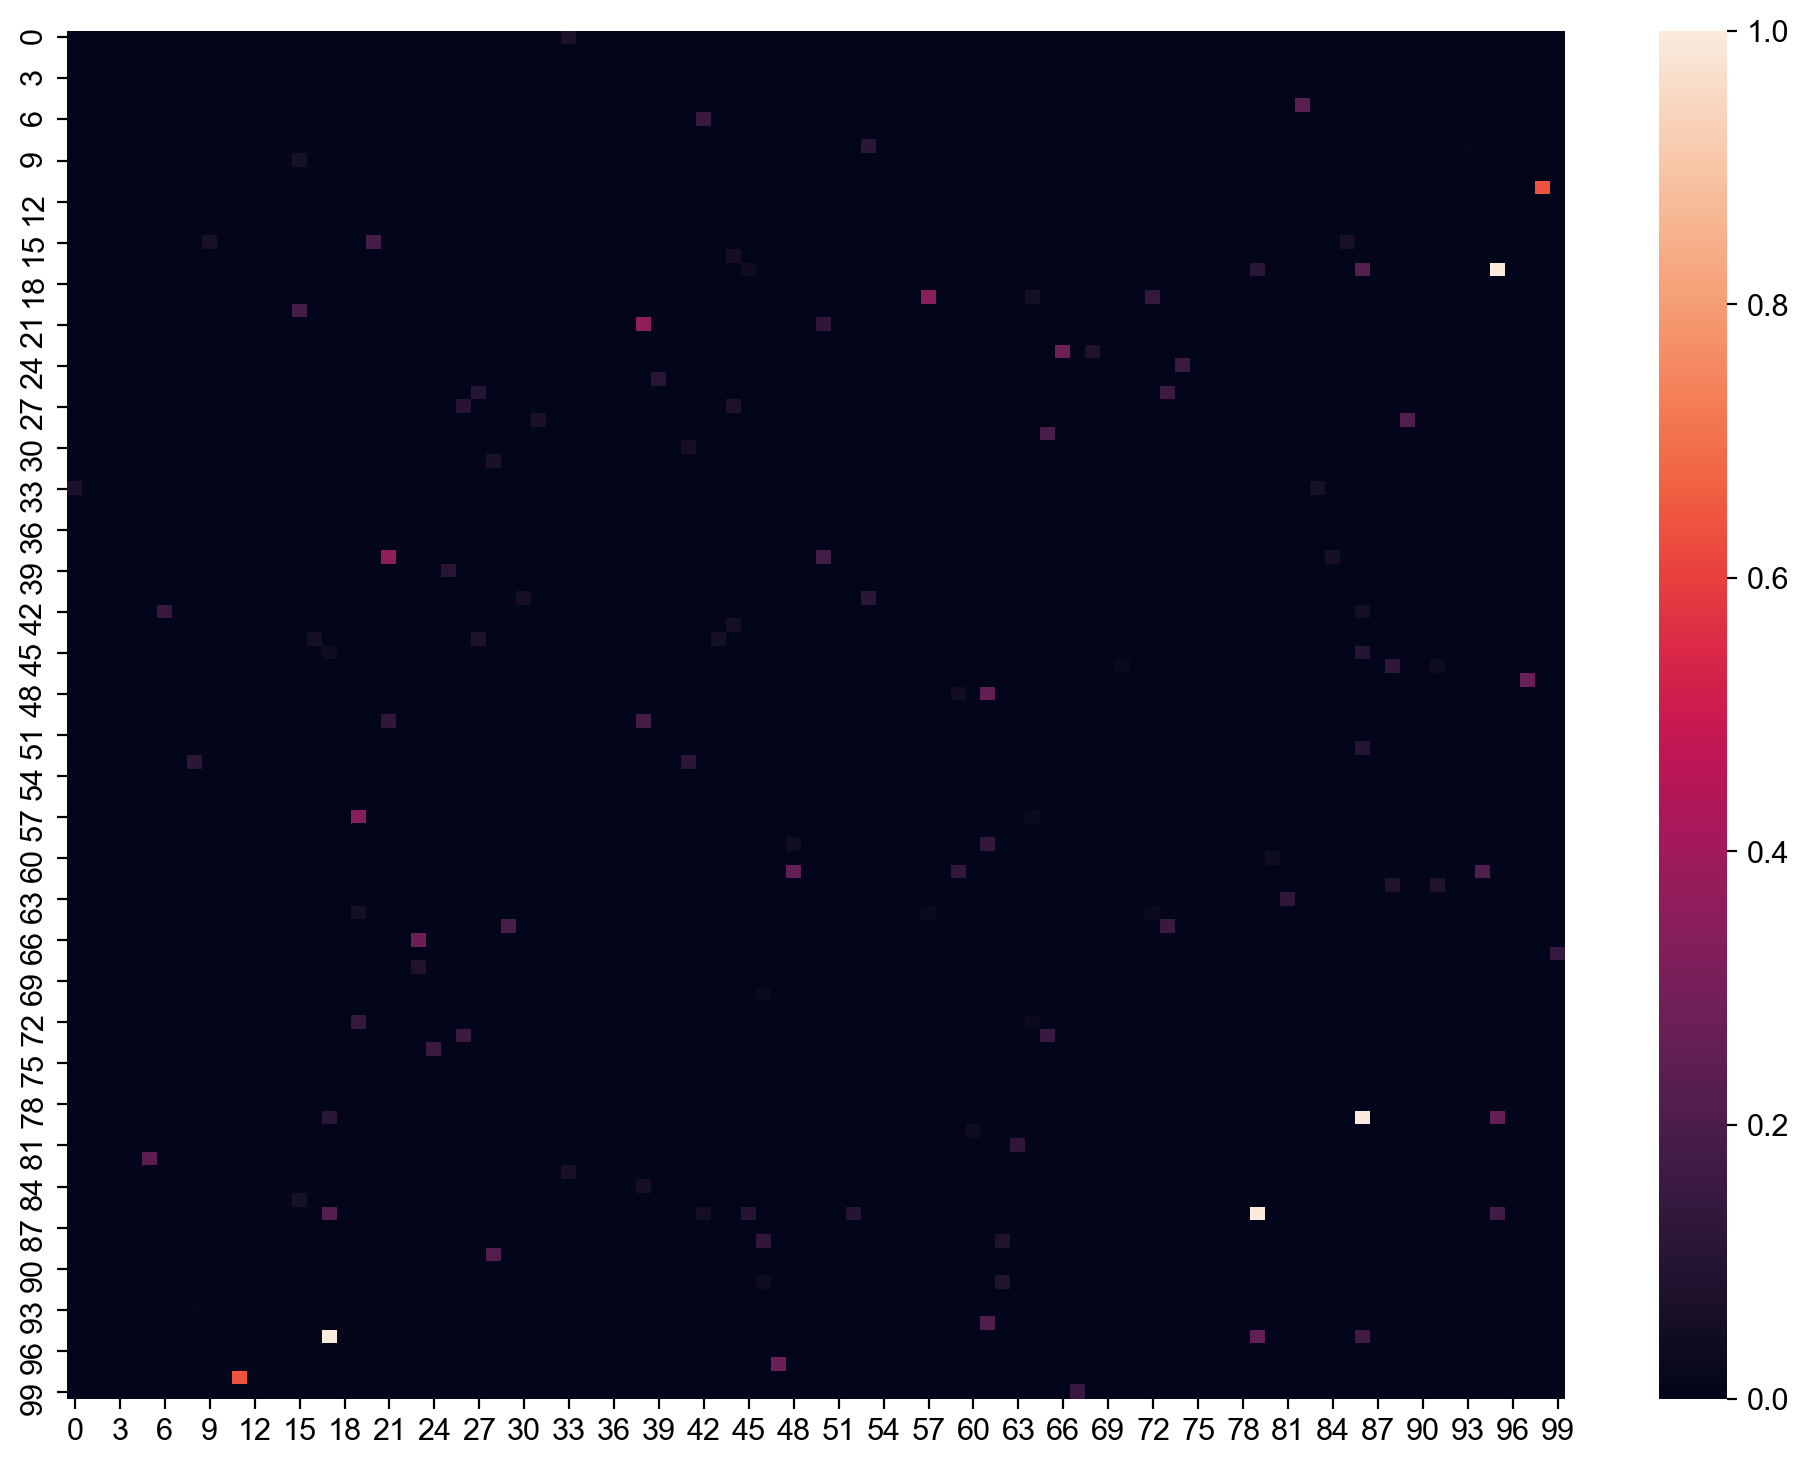

In [20]:
C = adata.obsp['connectivities'].toarray()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(C[:100, :100], ax=fig.gca())

In [21]:
fig.savefig("../pics/connectivities.png")

In [22]:
s = np.dot(connectivities, adata.layers['spliced'].toarray())[:, adata.var.index == gene][:,0]
u = np.dot(connectivities, adata.layers['unspliced'].toarray())[:, adata.var.index == gene][:,0]
c = adata.obs['clusters']

<AxesSubplot:>

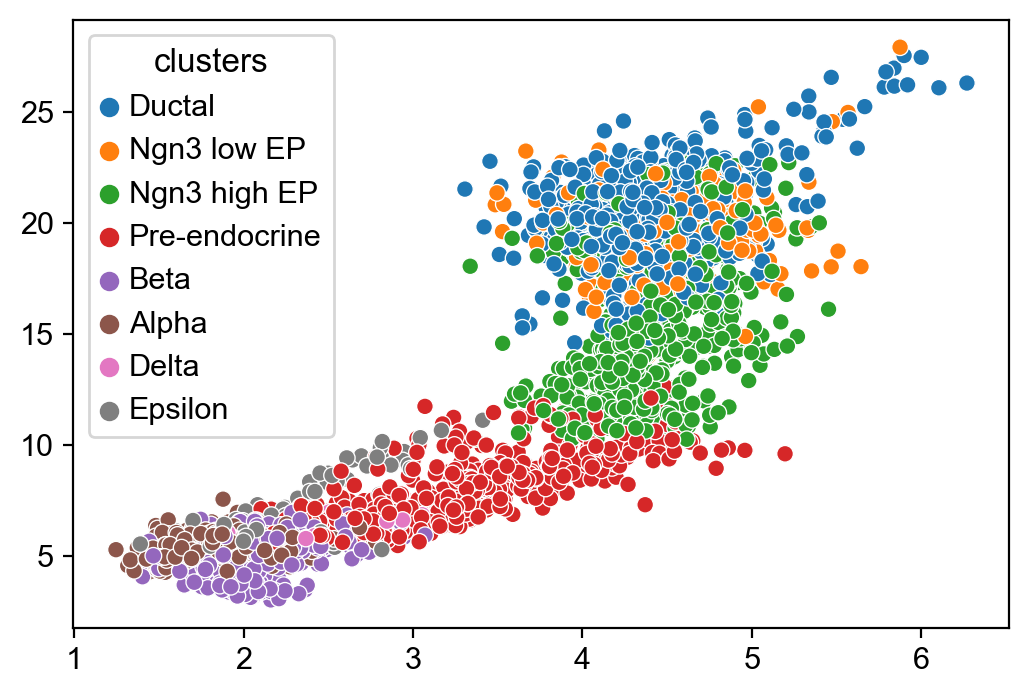

In [23]:
sns.scatterplot(x=s, y=u, hue=c)